In [844]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt

In [843]:
#stockPool is a huge array, good memory??

# 8192 minutes
# 5 day week = 7200 minutes
# use first 992 for steady state mean

stockPool = np.loadtxt('./fbm/fbm20uni.txt')
stockPool = stockPool[1:]

In [897]:
class portfolio:
    
    def __init__(self,name,size):
        self.stocks = np.random.choice(np.arange(20), size=size, replace=False)
        self.weights = dict.fromkeys(self.stocks,0) #init with a sharpe function, put in dictionary for easy change
        self.orders = np.zeros(size)
        self.portfID = str(name)
    
    def start(self,ti=92,tf=992):
        """
        initialize weights based on datapoints before the 5 day week
        """
        opt= np.int_(minimize(sharpe, list(a.weights.values()), args=(a.stocks,100,992), method='Nelder-Mead', tol=1e-6)['x'])
        
        for i,j in enumerate(a.stocks):
            a.weights[j] = opt[i]
    
    def order(self, time, opt):
        """
        returns the orders to be added to the broker dataframe
        immediately adjusts weights for sold stocks
        """
        self.orders = np.asarray(opt) - list(self.weights.values())
        orderList = pd.DataFrame({'time':time, "portfolio":self.portfID,"stock":self.stocks, "order": self.orders})
        
        # update weights that have been sent off
        i = 0
        for stock,weight in self.weights.items():
            if self.orders[i]<0:
                self.weights[stock] = weight + self.orders[i]
            i+=1
        return orderList
    
    def buy(self,stock,volume):
        """
        adjust recently bought stocks
        """
        
        print(self.weights)
        self.weights[stock] = self.weights[stock] + volume
        print(self.weights)
        

In [875]:
def sharpe(weights,stocks, ti, tf):
    """
    Input the stock ID numbers and calculate the negative sharpe ratio based on time
    """
    Rp = 0
    Rf = 0.01
    var = 0
    for i,j in enumerate(stocks): 
        #Rp += weights[i]*np.mean(stockPool[j][ti:tf]) #expected return up to point in time
        Rp += 100*weights[i]*(stockPool[j][tf]-stockPool[j][ti])/stockPool[j][ti] # actual expected return based on historical data
        var += weights[i]*weights[i]*np.var(stockPool[j][ti:tf]) #variance return up to point in time
    stdp = np.sqrt(var)
    
    return -(Rp-Rf)/stdp
    
    

In [896]:
# minimize from steady state based on fBM
print(a.stocks)
print(a.weights)
print(a.weights.values())
print(-sharpe(list(a.weights.values()),a.stocks,100,992))

opt = minimize(sharpe, list(a.weights.values()), args=(a.stocks,100,992), method='Nelder-Mead', tol=1e-6)['x']
opt = np.int_(opt)
print(opt)
print(-sharpe((opt),a.stocks,100,992))

for i,j in enumerate(a.stocks):
    a.weights[j] = opt[i]
    
print(a.weights)

[ 8 13 15  5 14 16 18 10 12  2]
{8: 40, 13: 2, 15: 2, 5: 35, 14: -20, 16: -54, 18: 32, 10: 11, 12: 20, 2: -26}
dict_values([40, 2, 2, 35, -20, -54, 32, 11, 20, -26])
6.423525471399668
[ 34   2   0  30 -17 -31  38   3  53 -21]
6.9873839627882735
{8: 34, 13: 2, 15: 0, 5: 30, 14: -17, 16: -31, 18: 38, 10: 3, 12: 53, 2: -21}


In [817]:
# to generate overlapping portfolios, scan through the stock list with various overlapping amounts. 
# for trades, generate an order book for each portfolio with the stocks they want to buy or sell, these are
# then matched to the closest order from another portfolio, a trade is agreed upon once the sum of their 
# sharpe ratios are maxamized by this trade

# INITIALIZE PORTFOLIO FUNCTION
# needs a dicitonary of all portfIDs and their portfolios

aopt = [-3,-2,-1,-2,-5,-1,-1,-1,-1,-3] 
a = portfolio('a',10)
#a.orders = np.asarray(aopt) - list(a.weights.values())
alist = a.order(1, aopt)

bopt = [3,4,5,6,7,8,2,0]
b = portfolio("b",8)
#b.orders = np.asarray(bopt) - list(b.weights.values())
blist = b.order(1, bopt)


copt = [3,4,5,6,7,8,2,0]
c = portfolio("c",8)
#c.orders = np.asarray(copt) - list(c.weights.values())
clist = c.order(1, copt)


dopt = [-3,-4,-5,6,-7,8,2,-2]
d = portfolio("d",8)
#d.orders = np.asarray(dopt) - list(d.weights.values())
dlist = d.order(2, dopt)

traderIDs = {'a':a,'b':b,'c':c,'d':d}

In [833]:
broker = pd.concat([alist,blist,clist,dlist])
broker = broker[broker.order!=0] # remove all null orders 
potMatch = broker[broker.groupby('stock').stock.transform(len) > 1] # removes all single orders
notMatch = broker[broker.groupby('stock').stock.transform(len) == 1]

In [834]:
traderIDs

{'a': <__main__.portfolio at 0x1021860668>,
 'b': <__main__.portfolio at 0x10218765f8>,
 'c': <__main__.portfolio at 0x10218396a0>,
 'd': <__main__.portfolio at 0x1021839710>}

In [835]:
orderList = pd.DataFrame()

for stock in (potMatch.stock.unique()): 
    # go through each stock and try to fill orders
    stockSearch = (potMatch[potMatch.stock == stock])
    buy = stockSearch[stockSearch.order > 0]
    sell = stockSearch[stockSearch.order < 0]
    if len(buy) == 0:
        notMatch = pd.concat([notMatch,sell])
    elif len(sell) == 0:
        notMatch = pd.concat([notMatch,buy])
    else:
        buy = buy.sort_values(by=["time",'order'],ascending=[True,False])
        sell = sell.sort_values(by=["time",'order'],ascending=[True,True])

        #print("BUY")
        #print(buy)
        #print("SELL")
        #print(sell)

        while len(buy) != 0 and len(sell) != 0:
            buy.reset_index(inplace=True,drop=True)
            sell.reset_index(inplace=True,drop=True)
            # iterate until no more matches
            sID = 0 # always look at the most important selling order first 
            print(buy)
            print(sell)
            sVol = sell.iloc[sID].order #selling amount

            #else:
            # algorithm that matches s with a b and updates sell and buy rows, take min and subtract until 0
            bMatch = buy.iloc[0]
            bVol = bMatch.order

            Vol = min(abs(sVol),abs(bVol))
            ToS = max(sell.iloc[sID].time, bMatch.time)

            sale = pd.DataFrame({"ToS":[ToS], "stock":stock, "seller": sell.iloc[sID].portfolio, 
                                 "buyer": bMatch.portfolio, "volume": Vol, 
                                 "tradeID": str(ToS)+'|'+str(stock)+str(sell.iloc[sID].portfolio)
                                +str(bMatch.portfolio)+str(-sVol)})

            orderList = pd.concat([orderList,sale])


            sell.set_value(sID, 'order', sell.iloc[sID].order + Vol)
            buy.set_value(0, 'order', bVol - Vol)


            print("sale")

            #update buyer weights
            print(bMatch.portfolio)
            print(traderIDs[bMatch.portfolio])
            buyer = traderIDs[bMatch.portfolio]
            buyer.buy(stock,Vol)


            buy = buy[buy.order!=0]
            sell = sell[sell.order!=0]
            print(buy)
            print(sell)
            print("______________ \n")

        if len(buy)==0:
            notMatch = pd.concat([notMatch,sell])
        else:
            notMatch = pd.concat([notMatch,buy])


                

   time portfolio  stock  order
0     1         b      8      7
   time portfolio  stock  order
0     1         a      8     -3
sale
b
{16: 12, 3: 0, 2: 18, 0: 0, 8: 18, 5: 30, 10: 6, 1: 0}
{16: 12, 3: 0, 2: 18, 0: 0, 8: 21, 5: 30, 10: 6, 1: 0}
   time portfolio  stock  order
0     1         b      8      4
Empty DataFrame
Columns: [time, portfolio, stock, order]
Index: []
______________ 

   time portfolio  stock  order
0     1         c     13      2
   time portfolio  stock  order
0     1         a     13     -2
1     2         d     13     -2
sale
c
{16: 9, 15: 15, 14: 22, 3: 0, 17: 0, 10: 27, 13: 11, 18: 0}
{16: 9, 15: 15, 14: 22, 3: 0, 17: 0, 10: 27, 13: 13, 18: 0}
Empty DataFrame
Columns: [time, portfolio, stock, order]
Index: []
   time portfolio  stock  order
1     2         d     13     -2
______________ 

   time portfolio  stock  order
0     1         c     15      4
   time portfolio  stock  order
0     1         a     15     -1
sale
c
{16: 9, 15: 15, 14: 22, 3: 0, 17: 0, 

/Users/braedyn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/braedyn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [831]:
orderList.sort_values(by='ToS', inplace=True)
orderList.reset_index(inplace=True,drop=True)
orderList

,ToS,stock,seller,buyer,volume,tradeID
0,1,8,a,b,3,1|8ab3
1,1,13,a,c,2,1|13ac2
2,1,15,a,c,1,1|15ac1
3,1,5,a,b,2,1|5ab2
4,1,14,a,c,5,1|14ac5
5,1,16,a,b,1,1|16ab1
6,1,10,a,c,1,1|10ac1
7,1,2,a,b,3,1|2ab3


In [840]:
notMatch

,time,portfolio,stock,order
6,1,a,18,-1
3,1,b,0,6
1,2,d,11,-4
2,2,d,19,-5
5,2,d,7,8
0,1,b,8,4
1,2,d,13,-2
0,1,c,15,3
0,1,b,5,6
1,2,d,14,-3


In [812]:
traderIDs

{'a': <__main__.portfolio at 0x10218394a8>,
 'b': 8,
 'c': <__main__.portfolio at 0x10212ff0b8>,
 'd': <__main__.portfolio at 0x1021011a90>}

In [778]:
buyer.weights

{15: 3, 8: 4, 1: 5, 10: 6, 13: 7, 14: 8, 17: 2, 7: 0}

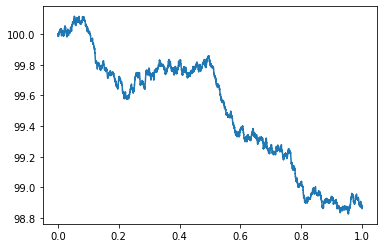

In [891]:
#for i in stockPool:
#    plt.plot(np.linspace(0,1,2**13+1)[100:],i[100:])

plt.plot(np.linspace(0,1,2**13+1),stockPool[16])
plt.show()


In [ ]:
 #if -sVol in buy.order.values:
                # see if there is a matching order to easily fill right away??
            #    bMatch = buy[buy.order.isin([-sVol])].iloc[0]
                #print(buy[buy.order.isin([-s])].index[0])

            #    ToS = max(sell.iloc[sID].time, bMatch.time)

            #    sale = pd.DataFrame({"ToS":[ToS], "stock":stock, "seller": sell.iloc[sID].portfolio, 
            #                         "buyer": bMatch.portfolio, "volume": -sVol, 
            #                         "tradeID": str(ToS)+'|'+str(stock)+str(sell.iloc[sID].portfolio)
            #                        +str(bMatch.portfolio)+str(-sVol)})

            #    orderList = pd.concat([orderList,sale])


            #    sell.set_value(sID, 'order', sell.iloc[sID].order - sVol)
            #    print(sell)
            #    buy.set_value(buy[buy.order.isin([-sVol])].index[0], 'order', bMatch.order + sVol)

            #    print(buy)

            #    print("sale made")
                #update buyer weights
            #    print(bMatch.portfolio)
            #    print(traderIDs[bMatch.portfolio])
            #    buyer = traderIDs[bMatch.portfolio]
            #    buyer.buy(stock,-sVol)